In [ ]:
# Validasyonda parametreleri öğrendikten sonra validasyonu da train içine kat

In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import subprocess; FOLDER_PATH = subprocess.Popen(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE).communicate()[0].rstrip().decode('utf-8')
import warnings; warnings.filterwarnings("ignore")
import sys, os; sys.path.append(os.path.dirname(f'{FOLDER_PATH}/utils')); sys.path.append(os.path.dirname(f'{FOLDER_PATH}/scripts'))

In [10]:
import pandas as pd
from time import time
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt

from gluonts.mx.trainer import Trainer
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.distribution import NegativeBinomialOutput, GaussianOutput, StudentTOutput, ZeroAndOneInflatedBetaOutput


from utils.base_helpers import read_data, split_data, scale_data
from utils.gluon_helpers import GluonTSWrapper, GluonTSModel

In [11]:
df = read_data(generate_speed_angle=True, add_lagged=True, number_of_plants=1)
train_df, valid_df, test_df = split_data(df, train_ratio=0.8, valid_ratio=0.1)
train_df, valid_df, test_df = scale_data(train_df, valid_df, test_df, scaler="minmax", expand=False)

Selected plants:
 [969]
Train start and end dates:	 2019-01-26 03:00:00 	 2021-06-22 09:00:00
Validation start and end dates:	 2021-06-22 10:00:00 	 2021-10-10 04:00:00
Test start and end dates:	 2021-10-10 05:00:00 	 2022-01-27 23:00:00


In [12]:
wrapper = GluonTSWrapper(train_df, valid_df, test_df, prediction_length=48, context_length=48)

4.020538330078125
1.155904769897461


In [13]:
train_ds, valid_ds, test_ds = wrapper.prepare_gluon_datasets()

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


In [14]:
model = GluonTSModel(DeepAREstimator, params={
    "num_layers": 3, 
    "trainer": Trainer(epochs=3, hybridize=False, num_batches_per_epoch=25, learning_rate=1e-3)
})()
predictor = model.train(training_data=train_ds, validation_data=valid_ds, num_workers=None)

100%|██████████| 25/25 [00:17<00:00,  1.45it/s, epoch=1/3, avg_epoch_loss=-.101]
4it [00:01,  2.34it/s, epoch=1/3, validation_avg_epoch_loss=0.0816]
100%|██████████| 25/25 [00:17<00:00,  1.47it/s, epoch=2/3, avg_epoch_loss=-.699]
4it [00:01,  2.02it/s, epoch=2/3, validation_avg_epoch_loss=-.415]
100%|██████████| 25/25 [00:17<00:00,  1.45it/s, epoch=3/3, avg_epoch_loss=-.906]
4it [00:01,  2.15it/s, epoch=3/3, validation_avg_epoch_loss=-.53]


In [15]:
valid_predictions, test_predictions = wrapper.make_prediction(predictor, valid_ds, test_ds)

In [16]:
valid_output, test_output = wrapper.evaluate_prediction(valid_df, test_df, valid_predictions, test_predictions)

Total validation WMAPE: 0.5516316027601977
   rt_plant_id     WMAPE
0          969  0.551632
Total test WMAPE: 0.6500174923003013
   rt_plant_id     WMAPE
0          969  0.650017


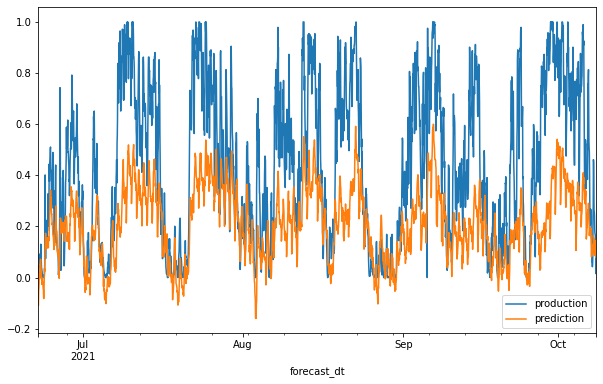

In [17]:
valid_output.loc[valid_output["rt_plant_id"] == 969, ["production", "prediction"]].plot(figsize=(10, 6));

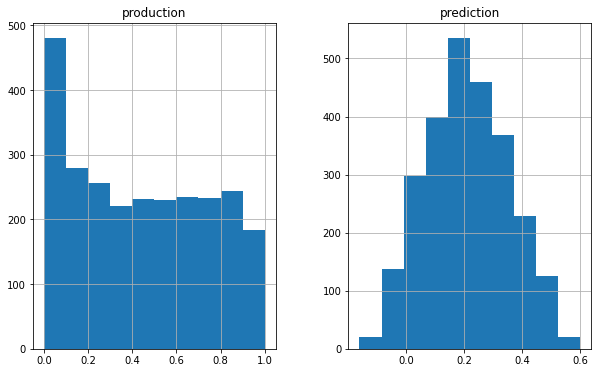

In [18]:
valid_output.loc[valid_output["rt_plant_id"] == 969, ["production", "prediction"]].hist(figsize=(10, 6));